<a href="https://colab.research.google.com/github/Elma-dev/fuel_calculation/blob/main/fuel_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json

In [302]:
#LV_data=pd.read_csv("LV2.csv", sep=";") #Read csv data
LV_data = pd.read_excel("LV1.xlsx")

In [304]:
LV_data.head()

,tracking_time,priority,longitude,latitude,altitude,angle,satellites,speed,km,message,...,device_id,vehicle_id,power,battery,volume_tank1,volume_tank2,signal,temperature,mat,code
0,2023-06-19 00:06:44,0,-5.860758,35.75858,97,0,10,0,0,NaN,...,1003651,1003161,13.014,13.014,NaN,NaN,5,NaN,61700-B-40 LV,61700-B-40 LV
1,2023-06-19 00:16:46,0,-5.860758,35.75858,72,0,11,0,0,NaN,...,1003651,1003161,13.014,13.014,NaN,NaN,5,NaN,61700-B-40 LV,61700-B-40 LV
2,2023-06-19 00:26:47,0,-5.860758,35.75858,72,0,12,0,0,NaN,...,1003651,1003161,13.016,13.016,NaN,NaN,5,NaN,61700-B-40 LV,61700-B-40 LV
3,2023-06-19 00:39:06,0,-5.860758,35.75858,90,0,11,0,0,NaN,...,1003651,1003161,13.010,13.010,NaN,NaN,5,NaN,61700-B-40 LV,61700-B-40 LV
4,2023-06-19 00:49:07,0,-5.860758,35.75858,71,0,9,0,0,NaN,...,1003651,1003161,13.013,13.013,NaN,NaN,5,NaN,61700-B-40 LV,61700-B-40 LV


In [305]:
LV_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8718 entries, 0 to 8717
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tracking_time               8718 non-null   datetime64[ns]
 1   priority                    8718 non-null   int64         
 2   longitude                   8718 non-null   float64       
 3   latitude                    8718 non-null   float64       
 4   altitude                    8718 non-null   int64         
 5   angle                       8718 non-null   int64         
 6   satellites                  8718 non-null   int64         
 7   speed                       8718 non-null   int64         
 8   km                          8718 non-null   int64         
 9   message                     0 non-null      float64       
 10  can_speed                   8718 non-null   int64         
 11  accelerator_pedal_position  8718 non-null   int64       

## before remove 0 values

In [88]:
#Alv values
fuel_time={"tracking_time":[],"fuel_level":[]}
for i,alv in enumerate(LV_data.alv_data.values):
  alv_value=json.loads(alv)
  if alv_value.get("84")!=None:
    #if float(alv_value.get("84"))!=0:
      fuel_time["tracking_time"].append(LV_data.at[i,"tracking_time"])
      fuel_time["fuel_level"].append(float(alv_value.get("84"))*0.1)
fuel_time_pd=pd.DataFrame(data=fuel_time)

In [89]:
fuel_time_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4415 entries, 0 to 4414
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tracking_time  4415 non-null   datetime64[ns]
 1   fuel_level     4415 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 69.1 KB


In [90]:
px.line(data_frame=fuel_time_pd,x="tracking_time",y="fuel_level")

## After removing 0 values (Run This)

In [306]:
pd.unique(LV_data.mat) # Show Matricules we have in data

array(['61700-B-40 LV', '78541.B.40 LV'], dtype=object)

In [307]:
def loadData(data,matricule,code="84",percent=False,sizeTotale=0):
  #Select the data of matriculeX
  data=data[data.mat==matricule].reset_index()
  #Alv values
  fuel_time={"tracking_time":[],"fuel_level":[]}
  j=0
  for i,alv in enumerate(data.alv_data.values):
    alv_value=json.loads(alv)
    if alv_value.get(code)!=None:
      if float(alv_value.get(code))==0:
        fuel_time["tracking_time"].append(data.at[i,"tracking_time"])
        if percent==True:
          fuel_time["fuel_level"].append(j*sizeTotale/100)
        else:
          fuel_time["fuel_level"].append(j*0.1)
      elif float(alv_value.get(code))!=0:
        j=float(alv_value.get(code))
        fuel_time["tracking_time"].append(data.at[i,"tracking_time"])
        #multiply the fuel_level by 0.1 to get the result in Litters.
        if percent==False:
          fuel_time["fuel_level"].append(float(alv_value.get(code))*0.1)
        else:
          fuel_time["fuel_level"].append(float(alv_value.get(code))*sizeTotale/100)
  fuel_time_pd=pd.DataFrame(data=fuel_time)
  #fuel_time_pd=fuel_time_pd.iloc[len(fuel_time_pd[fuel_time_pd.fuel_level==0]):,] # remove first off values
  return fuel_time_pd

In [308]:
fuel_time_pd=loadData(LV_data,matricule="78541.B.40 LV",code="84",percent=False)
#fuel_time_pd=loadData(LV_data,matricule="25896-A-73 LV",code="89",percent=True,sizeTotale=310)
fuel_time_pd.head()

,tracking_time,fuel_level
0,2023-06-19 00:04:01,0.0
1,2023-06-19 00:14:02,0.0
2,2023-06-19 00:24:03,0.0
3,2023-06-19 00:34:04,0.0
4,2023-06-19 00:44:05,0.0


In [309]:
px.line(data_frame=fuel_time_pd,x="tracking_time",y="fuel_level")

<Axes: xlabel='tracking_time', ylabel='fuel_level'>

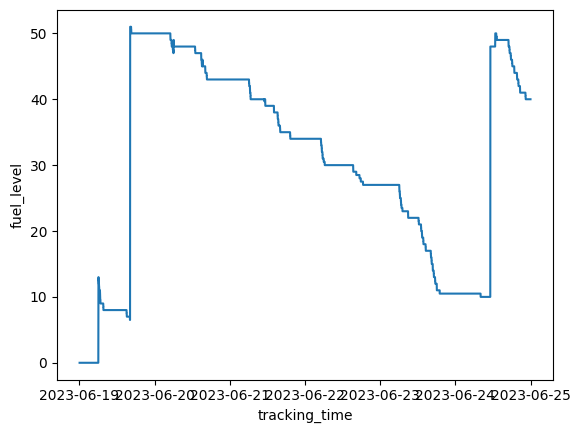

In [323]:
sns.lineplot(data=fuel_time_pd,x="tracking_time",y="fuel_level")

## Fuel Size Versus Angle

In [ ]:
#Alv values
fuel_time={"tracking_time":[],"fuel_level":[],"angle":[]}
for i,alv in enumerate(LV_data.alv_data.values):
  alv_value=json.loads(alv)
  if alv_value.get("84")!=None:
    if float(alv_value.get("84"))!=0:
      fuel_time["tracking_time"].append(LV_data.at[i,"tracking_time"])
      fuel_time["angle"].append(LV_data.at[i,"angle"])
      fuel_time["fuel_level"].append(float(alv_value.get("84"))*0.1)
fuel_time_pd=pd.DataFrame(data=fuel_time)

In [ ]:
fuel_time_pd

,tracking_time,fuel_level,angle
0,2023-06-19 06:03:32,13.0,223
1,2023-06-19 06:03:38,13.0,347
2,2023-06-19 06:03:52,13.0,285
3,2023-06-19 06:04:04,13.0,333
4,2023-06-19 06:04:25,13.0,278
...,...,...,...
3969,2023-06-24 22:48:48,40.0,148
3970,2023-06-24 22:49:13,40.0,148
3971,2023-06-24 22:49:21,40.0,148
3972,2023-06-24 22:59:23,40.0,148


In [ ]:
px.line(data_frame=fuel_time_pd,x="tracking_time",y="fuel_level",text="angle")

## Add Altitude

In [ ]:
#Alv values
fuel_time={"tracking_time":[],"fuel_level":[],"angle":[],"altitude":[]}
for i,alv in enumerate(LV_data.alv_data.values):
  alv_value=json.loads(alv)
  if alv_value.get("84")!=None:
    if float(alv_value.get("84"))!=0:
      fuel_time["tracking_time"].append(LV_data.at[i,"tracking_time"])
      fuel_time["angle"].append(LV_data.at[i,"angle"])
      fuel_time["altitude"].append(LV_data.at[i,"altitude"])
      fuel_time["fuel_level"].append(float(alv_value.get("84"))*0.1)
fuel_time_pd=pd.DataFrame(data=fuel_time)

In [ ]:
fuel_time_pd

,tracking_time,fuel_level,angle,altitude
0,2023-06-19 06:03:32,13.0,223,50
1,2023-06-19 06:03:38,13.0,347,61
2,2023-06-19 06:03:52,13.0,285,59
3,2023-06-19 06:04:04,13.0,333,56
4,2023-06-19 06:04:25,13.0,278,47
...,...,...,...,...
3969,2023-06-24 22:48:48,40.0,148,104
3970,2023-06-24 22:49:13,40.0,148,104
3971,2023-06-24 22:49:21,40.0,148,104
3972,2023-06-24 22:59:23,40.0,148,104


In [ ]:
fuel_time_pd.head(1000)

,tracking_time,fuel_level,angle,altitude
0,2023-06-19 06:03:32,13.0,223,50
1,2023-06-19 06:03:38,13.0,347,61
2,2023-06-19 06:03:52,13.0,285,59
3,2023-06-19 06:04:04,13.0,333,56
4,2023-06-19 06:04:25,13.0,278,47
...,...,...,...,...
995,2023-06-20 16:22:46,44.0,5,384
996,2023-06-20 16:22:55,44.0,277,381
997,2023-06-20 16:22:57,44.0,230,381
998,2023-06-20 16:23:14,44.0,155,381


In [ ]:
px.line(data_frame=fuel_time_pd,x="tracking_time",y="fuel_level",text="altitude")

#**Cleaning Data Functions**

In [310]:
def increasingtPts():
  #found increasing point
  pts=[]
  #pts.append(fuel_time_pd.at[0,'fuel_level'])
  for i in range(fuel_time_pd['fuel_level'].size-1):
    if fuel_time_pd['fuel_level'].values[i] < fuel_time_pd['fuel_level'].values[i+1]:
      if (fuel_time_pd['fuel_level'].values[i+1]-fuel_time_pd['fuel_level'].values[i])>=7:
        pts.append((fuel_time_pd['fuel_level'].values[i] , fuel_time_pd['fuel_level'].values[i+1]))
  return pts

In [311]:
#Test
increasingtPts()

[(0.0, 13.0), (6.5, 51.0), (10.0, 48.0)]

In [312]:
def avg(pts):
  sum=0
  for i,j in pts:
    sum+=j-i
    #print(sum)
  increasingAvg=sum/len(pts)
  return increasingAvg

In [313]:
#Test
avg(increasingtPts())

31.833333333333332

In [314]:
def isIncreasingPt(x1,x2):
  return x2>x1

In [315]:
def realIncPts(dist,avgIncr):
  return dist>=avgIncr

In [316]:
def searchCorrectVal(currentIdx,data):
  i=currentIdx-1
  while i>0:
    if data[i]>data[currentIdx]:
      return i
    i-=1
  return -1

In [317]:
def cleaningData(preparedData):
  #Calculate Increasing Avg
  avgIncreasing=avg(increasingtPts())
  for i in range(preparedData['fuel_level'].size-1):
    x1,x2=preparedData['fuel_level'].values[i] , preparedData['fuel_level'].values[i+1]
    #if is increasing point
    if isIncreasingPt(x1,x2):
      #calculate the increasing value
      dist=preparedData['fuel_level'].values[i+1]-preparedData['fuel_level'].values[i]
      #if the increasing is less than the avg value => wrong value
      if not realIncPts(dist,avgIncreasing):
        #replace it with the right value
        idx=searchCorrectVal(i+1,preparedData['fuel_level'].values)
        nbrPoints=i-idx
        #avoid case
        if nbrPoints<1000:
          #print(preparedData['tracking_time'].values[idx+1],preparedData['tracking_time'].values[i+1])
          #replace
          preparedData.loc[idx+1:i,'fuel_level']=preparedData['fuel_level'].values[i+1]
  preparedData=preparedData.iloc[len(preparedData[preparedData.fuel_level==0]):,]
  return preparedData

In [318]:
#test
cleanData=cleaningData(preparedData=loadData(LV_data,matricule="78541.B.40 LV",code="84",percent=False))
#cleanData=cleaningData(preparedData=loadData(LV_data,matricule="25896-A-73 LV",code="89",percent=True,sizeTotale=310))

In [319]:
cleanData.head()

,tracking_time,fuel_level
0,2023-06-19 00:04:01,13.0
1,2023-06-19 00:14:02,13.0
2,2023-06-19 00:24:03,13.0
3,2023-06-19 00:34:04,13.0
4,2023-06-19 00:44:05,13.0


In [320]:
#plot cleaning data
px.line(data_frame=cleanData,x="tracking_time",y="fuel_level",title="Clening Data Plot")

#**Fuel Consumed Calculation**

\begin{equation}
  TotalFuelConsumed=\sum_{i=1}^{n}ConsumedValue_{i}
\end{equation}

\begin{equation}
  ConsumedValue_i=(refuelLevel - initialLevel)
\end{equation}

In [321]:
#Algorithm fuel level Calculation
def calculateConsumedFuel(clean_data):
  data = clean_data
  #dataFrame.diff() => xi+1 - xi (decreasing<0 / increasing >0)
  data['fuel_diff'] = data['fuel_level'].diff() # Calculate the difference between consecutive fuel levels
  data.loc[data['fuel_diff'] > 0, 'fuel_diff'] = 0 # If the fuel level increases, we set the difference to 0
  total_fuel_consumed = abs(data['fuel_diff'].sum()) # The total fuel consumed is the absolute sum of the fuel differences
  return total_fuel_consumed

In [322]:
#Test Algorithm
print(f'Total fuel consumed: {calculateConsumedFuel(cleanData)} L')

Total fuel consumed: 57.5 L


In [235]:
#Manual calculation
total_fuel_consumed_M = (13-6.5)+(51-10)+(50-40)
print(f'Total fuel consumed: {total_fuel_consumed_M} L')

Total fuel consumed: 57.5 L


# Web API

In [ ]:
# !pip install fastapi
# !pip install uvicorn
# !pip install requests
# !pip install pyngrok
# !pip install nest-asyncio

In [ ]:
# from fastapi import FastAPI
# import uvicorn
# from pyngrok import ngrok
# from fastapi.middleware.cors import CORSMiddleware

In [ ]:
# app = FastAPI()

In [ ]:
# origins = ["*"]

# app.add_middleware(
#     CORSMiddleware,
#     allow_origins = origins,
#     allow_credentials = True,
#     allow_methods = ["*"],
#     allow_headers = ["*"]
# )

In [ ]:
# @app.post('/data_cleaning')
# def cleaning_service(data):
